# Beer Recipe Recommendation Engine

This notebook performs analysis on scraped webpages from beersmith.com. Beersmith is a website for hobby home brewers to share recipes, and for other brewers to rate the shared recipes. If we organize the results into a User x Recipe matrix, we can create an SVD Recommendation Engine in line with the winning solution of the Netflix Prize. In this analysis, we ignore the cold start problem as we have insufficient data to handle it.

To perform the majority of analysis, I have decided to use the Surprise library by Nicolas Hug. The library is built in a style similar to sci-kit learn, but is designed specifically for recommendation engines. The main difference is the handling of missing data. Sci-kit assumes no missing data in the predictive algorithms, which is not possible for recommmendation engines. Surprise assumes the majority of entries are missing. 

## Importing Data

I created a custom parser to deal with the webpages. Beautiful Soup struggled to deal with the BeerXML format in which the recipes are stored online, and the BeerXML library struggled to deal with webpages. It was easier to create a custome parser rather than trying to get the two libraries to work together.

In [1]:
import pandas as pd
import numpy as np
import os
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader
from surprise.dataset import Dataset

from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp

from surprise.model_selection import train_test_split
from surprise.model_selection import RepeatedKFold
from surprise.model_selection import KFold

from surprise.model_selection.search import GridSearchCV
from surprise.evaluate import GridSearch

from surprise import accuracy

from src.Parser import Parser
%matplotlib inline 

In [39]:
fls    = os.listdir('recipes/')
receps = []

for fl in fls:
    beer = Parser('recipes/' + fl)
    if beer.ratings is not None:
        receps.append(beer)

In [40]:
ratings = [beer.ratings for beer in receps]
ratings = pd.concat(ratings)
ratings.to_csv('ratings.csv')
ratings = ratings[[x in ['10', '20', '30', '40', '50'] for x in ratings.Rating]]
ratings['Rating'] = pd.to_numeric(ratings['Rating']) / 10
ratings = ratings[['User', 'Recipe', 'Rating']]

## Preliminary Exploratory Analysis

Before creating the train-test splits, perform a cursory EDA to make sure that there are no glaring errors. This dataset is fairly simple as we only care about the fields | User | Item | Rating |. We are interested to see that ratings are integers, and that we have a wide coverage of users and items. Additionally, we would like users to rate multiple recipes so that we can infer preferences. 

In [4]:
ratings.head()

,User,Recipe,Rating
0,3624/dsullivan,10088,5.0
0,3624/dsullivan,10089,5.0
0,439/brewdog,10127,4.0
0,38954/cwbyflip,10190,5.0
0,391/brewhays,10205,4.0


Observations Collected:	1678

Unique Useable Recipes:	402

Unique Users:	708

Total Shape:	915


             User Recipe  Rating
0  3624/dsullivan  10088     5.0
0  3624/dsullivan  10089     5.0
0     439/brewdog  10127     4.0
0  38954/cwbyflip  10190     5.0
0    391/brewhays  10205     4.0


Axes(0.125,0.125;0.775x0.755)


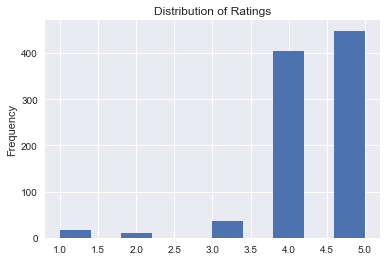

In [5]:
print('Observations Collected:\t' + str(len(fls)))
print('\nUnique Useable Recipes:\t' + str(len(set(ratings.Recipe))))
print('\nUnique Users:\t' + str(len(set(ratings.User))))
print('\nTotal Shape:\t' + str(ratings.shape[0]) + '\n\n')
print(ratings.head())
print('\n')
print(ratings.Rating.plot(kind = 'hist', title = 'Distribution of Ratings'))

It looks like we collected data on 1,678 recipes. Of those, 915 had at least 1 rating. There were 402 unique recipes, and 708 users provided the ratings. The ratings are integers from 1 - 5, with the majority of ratings being 4 - 5. With some knowledge of homebrewing, the high ratings are somewhat intuitive. If a user puts in 5 weeks of time creating a new batch, they may have some biases that cause them to rate the product highly. 

### Most Active Users and Most Rated Recipes

I suspect that the most active users make up a large portion of the total comments in line with Power Laws. Similarly, the most rated recipes likely dominate the total count of ratings. Examine how extreme this effect is. 

In [6]:
ratings.\
    groupby('Recipe')['User'].\
           count().\
                sort_values(ascending=False).\
                           head(10)

Recipe
1645     83
653      55
17432    43
17560    37
3684     28
1449     15
199      15
1834     14
2535     13
654      13
Name: User, dtype: int64

In [7]:
ratings.\
    groupby('User')['Recipe'].\
           count().\
                sort_values(ascending=False).\
                           head(10)

User
439/brewdog          27
445/oudrank12        13
92/timlael            8
1/beersmith           7
3584/dchijarhead      7
41/thehopfather       6
212/mattcrecelius     6
26/brulosopher        6
120867/mapuluxo       5
618/zymurgist05       5
Name: Recipe, dtype: int64

It appears that brewdog is extremely active compared to the top 10 active users, and that recipe 1,645 was the most rated by a large margin. The converse of this is that there are likely a large number of thinly rated recipes, or inactive users. Out of conservatism, look to increase regularization. 

In [8]:
print(ratings.Rating.describe())
print(set(ratings.Rating))

count    915.000000
mean       4.372678
std        0.775667
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64
{1.0, 2.0, 3.0, 4.0, 5.0}


In [12]:
pd.DataFrame({'Recipe' : pd.to_numeric(ratings['Recipe']), 'Rating' : ratings.Rating}).corr()

,Rating,Recipe
Rating,1.000000,-0.024361
Recipe,-0.024361,1.000000


## Benchmark

We now have an idea of the distribution of the data. The next step is to set aside data for a test set, to create a benchmark for the cross validation set. The recipe number corresponds to the number used by Beersmith to store the recipe. After some spot checks, it appears that the number roughly corresponds to time the recipe was uploaded. After a quick correlation analysis, this number is uncorrelated with the rating. We should assume IID data, and used K Fold cross validation to make the best use of the data. To avoid bad samples, and because the dataset is small, use Repeated K-Fold cross validation. 

Additionally, we should establish a test set, and only use the test set to approximate the model error on new data. Due to the small data, 75% and 25% test seems reasonable. We will optimize the model on RMSE in line with the Netflix solution. 

In [41]:
reader = Reader(rating_scale=(1, 5))
data   = Dataset.load_from_df(ratings, reader)

random.seed(42)
random.shuffle(data.raw_ratings)
cut_off = int(len(data.raw_ratings) * 0.75)

train_ratings = data.raw_ratings[:cut_off]
test_ratings  = data.raw_ratings[cut_off:]

data.raw_ratings = train_ratings

In [10]:
def evaluator(algo, df, cv_method, verbose = False):
    """
    wrapper to streamline evaluation
    """

    results = []    
    cntr    = 0
    for train_set, test_set in cv_method.split(df):
        algo.fit(train_set)
        predictions = algo.test(test_set)
        accrcy      = accuracy.rmse(predictions)
        results.append(pd.DataFrame({'Fold'  : [cntr], 
                                     'RMSE'  : [accrcy]}))
        cntr += 1
    
    results = pd.concat(results)
    
    if verbose:
        return results
    else:
        return [results['RMSE'].mean(), results['RMSE'].std()]

In [11]:
#Algos 
cv_method    = RepeatedKFold(
                      n_splits = 5, 
                      n_repeats = 3, 
                      random_state = 42)

algo         = BaselineOnly(verbose = False)  

#CV
cv_score     = evaluator(algo, 
                         data, 
                         cv_method)
#Bias
train_set    = data.build_full_trainset()
algo.fit(train_set)
preds        = algo.test(train_set.build_testset())
bias         = accuracy.rmse(preds)

#Error
test_set     = data.construct_testset(test_ratings)
preds        = algo.test(test_set)
err          = accuracy.rmse(preds)

#Baseline CV
print('\nBaseline CV avg:\t' + str(cv_score[0]))
print('\nBaseline CV std:\t' + str(cv_score[1]))
print('\nBaseline bias:\t' + str(bias))
print('\nBaseline OOS error:\t' + str(err))

RMSE: 0.7845
RMSE: 0.5855
RMSE: 0.6806
RMSE: 0.8115
RMSE: 0.7711
RMSE: 0.7545
RMSE: 0.5899
RMSE: 0.6503
RMSE: 0.8596
RMSE: 0.7633
RMSE: 0.6904
RMSE: 0.7666
RMSE: 0.8446
RMSE: 0.6039
RMSE: 0.7228
RMSE: 0.6337
RMSE: 0.8123

Baseline CV avg:	0.7252773998100065

Baseline CV std:	0.08894910203752512

Baseline bias:	0.6336654807090152

Baseline OOS error:	0.8122892454374215


Our baseline model uses the average gloval rating, the average recipe rating, and the average user rating in the train set, to make a prediction on the validation and test sets. Using this simple approach, we can get a cross validation score of 0.725, and the baseline OOS error is 0.812, which is just outside of a standard error in the CV. This is reasonable=, proceed with more in depth analysis. 

## In Depth EDA

Now that we have set benchmarks, and set aside the test set, we can perform some more in depth EDA without substantially risking overfitting to the dataset. This mainly involves examining volatile ratings.   



Description of Ratings

count    327.000000
mean       2.097859
std        4.961468
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       63.000000
Name: count, dtype: float64


Count Frequencies of Number of Recipe Ratings

count
1     246
2      44
3      10
4      10
5       3
6       2
7       1
9       3
10      1
12      2
21      1
31      1
35      1
37      1
63      1
Name: mean, dtype: int64


Most Volatile Ratings

            mean       std  count
Recipe                           
211     3.000000  2.000000      3
10490   4.333333  1.154701      3
1449    4.500000  0.674200     12
688     4.500000  0.577350      4
6503    4.666667  0.577350      3
3684    4.666667  0.577350     21
1618    4.333333  0.577350      3
742     4.666667  0.577350      3
1438    4.666667  0.577350      3
14573   4.666667  0.577350      3
Axes(0.125,0.125;0.775x0.755)


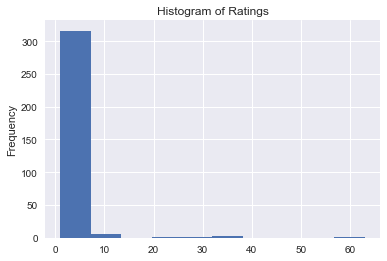

In [12]:
ratings_eda = pd.DataFrame(train_ratings)
ratings_eda = ratings_eda[[0, 1, 2]]
ratings_eda.columns = ['User', 
                       'Recipe',
                       'Rating']
ratings_sd = ratings_eda.groupby('Recipe').agg(['mean', 'std', 'count'])
ratings_sd.columns = ratings_sd.columns.levels[1] 

print('\n')
print('Description of Ratings\n')
print(ratings_sd['count'].describe())
print('\n')
print('Count Frequencies of Number of Recipe Ratings\n')
print(ratings_sd.groupby('count')['mean'].count())
print('\n')
print('Most Volatile Ratings\n')
print(ratings_sd[ratings_sd['count'] > 2].sort_values('std', ascending=False).head(10))
print(ratings_sd['count'].plot(kind = 'hist', title = 'Histogram of Ratings'))

From our more in depth EDA, most recipes have 1 ratings, while a select few have more than 5. This data is very sparse, and we may be required to get more ratings before progressing further. In later stages of analysis, examine the impact of adding more data. 

In addition, it looks like a few recipes have very different ratings. Recipe 211 for example has 3 ratings, which are 1, 3, 5. In the movie literature, this has become known as the Napolean Dynamite effect, which the item is controversial, so ratings are divided. This is hard to correct for, but may be useful for evaluating the model, and seeing how it responds to these situations.

## Model Fitting

My general model fitting procedure on small datasets is to use repeated K Fold CV, and a grid search over the hyperparameters. On the repeated K Fold, I change the seed so that is is somewhate different than the sets used to select between models. Upon completion of the CV results, explore the distribution across cross sections of hyperparameters to ensure that the final set is around the global minimum. 

In [13]:
cv_method    = RepeatedKFold(n_splits = 5, 
                             n_repeats = 5, 
                             random_state = 1)

### KNN Model

The KNN model identifies users with the most similar ratings to the candiate user, and makes a prediciton using the ratings of those users. With a very sparse dataset, it may be difficult to get a good estimate of the ratings. 

In [14]:
param_grid = {'k'       : [4, 8, 16, 32, 64],
              'min_k'   : [1, 2, 3, 4],
             'verbose'  : [False]}

clf_knn = GridSearchCV(KNNBasic,
                   param_grid,
                   cv = cv_method)

clf_knn.fit(data)
results_df = pd.DataFrame.from_dict(clf_knn.cv_results)
results_df.sort_values('mean_test_rmse', inplace = True)
results_df.head(10)

,mean_fit_time,mean_test_mae,mean_test_rmse,mean_test_time,param_k,param_min_k,param_verbose,params,rank_test_mae,rank_test_rmse,...,split7_test_mae,split7_test_rmse,split8_test_mae,split8_test_rmse,split9_test_mae,split9_test_rmse,std_fit_time,std_test_mae,std_test_rmse,std_test_time
19,0.006900,0.604724,0.75049,0.001917,64,4,False,"{'k': 64, 'min_k': 4, 'verbose': False}",1,1,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007785,0.030757,0.063535,0.005075
2,0.005626,0.604724,0.75049,0.002500,4,3,False,"{'k': 4, 'min_k': 3, 'verbose': False}",2,2,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007502,0.030757,0.063535,0.005729
3,0.006252,0.604724,0.75049,0.002496,4,4,False,"{'k': 4, 'min_k': 4, 'verbose': False}",3,3,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007658,0.030757,0.063535,0.005720
15,0.007500,0.604724,0.75049,0.001875,32,4,False,"{'k': 32, 'min_k': 4, 'verbose': False}",4,4,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007812,0.030757,0.063535,0.005077
14,0.006875,0.604724,0.75049,0.001876,32,3,False,"{'k': 32, 'min_k': 3, 'verbose': False}",5,5,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007756,0.030757,0.063535,0.005079
6,0.006250,0.604724,0.75049,0.001875,8,3,False,"{'k': 8, 'min_k': 3, 'verbose': False}",6,6,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007654,0.030757,0.063535,0.005078
7,0.005000,0.604724,0.75049,0.002500,8,4,False,"{'k': 8, 'min_k': 4, 'verbose': False}",7,7,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007289,0.030757,0.063535,0.005728
18,0.005626,0.604724,0.75049,0.001874,64,3,False,"{'k': 64, 'min_k': 3, 'verbose': False}",8,8,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007501,0.030757,0.063535,0.005076
10,0.005625,0.604724,0.75049,0.003126,16,3,False,"{'k': 16, 'min_k': 3, 'verbose': False}",9,9,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.007499,0.030757,0.063535,0.006252
11,0.005905,0.604724,0.75049,0.003172,16,4,False,"{'k': 16, 'min_k': 4, 'verbose': False}",10,10,...,0.620066,0.78124,0.562709,0.699529,0.6198,0.773981,0.006739,0.030757,0.063535,0.005812


### SVD

The SVD model decomposes the error term of the baseline model into user matrices, and item matrices using the SVD. Regularization is used to limit the size of individual parameters, and the amount of regularization is chosen to minimize RMSE. 

In [17]:
param_grid = {'n_factors'  : np.arange(25, 225, 25),
              'n_epochs'   : np.arange(5, 25, 5),
              'lr_all'     : np.arange(0.02, 0.14, 0.02),
              'reg_all'    : np.arange(0, 0.14, 0.02)}

clf_svd = GridSearchCV(SVD,
                       param_grid,
                       cv = cv_method)
clf_svd.fit(data)

results_df = pd.DataFrame.from_dict(clf_svd.cv_results)
results_df.sort_values('mean_test_rmse', inplace = True)
results_df.head(10)

,mean_fit_time,mean_test_mae,mean_test_rmse,mean_test_time,param_lr_all,param_n_epochs,param_n_factors,param_reg_all,params,rank_test_mae,...,split7_test_mae,split7_test_rmse,split8_test_mae,split8_test_rmse,split9_test_mae,split9_test_rmse,std_fit_time,std_test_mae,std_test_rmse,std_test_time
704,0.043386,0.538198,0.719632,0.006248,0.10,15,100,0.00,"{'n_factors': 100, 'n_epochs': 15, 'lr_all': 0...",269,...,0.564657,0.760938,0.509438,0.675748,0.550124,0.727899,0.009333,0.036095,0.072986,0.007652
888,0.058541,0.541044,0.719821,0.003126,0.08,15,125,0.00,"{'n_factors': 125, 'n_epochs': 15, 'lr_all': 0...",451,...,0.561340,0.757359,0.521804,0.680871,0.544210,0.725595,0.010427,0.035305,0.072076,0.006251
481,0.038863,0.542169,0.719897,0.003128,0.02,15,75,0.02,"{'n_factors': 75, 'n_epochs': 15, 'lr_all': 0....",524,...,0.568928,0.762380,0.516941,0.679769,0.554705,0.733620,0.007723,0.034026,0.070929,0.006256
49,0.015667,0.544190,0.720018,0.001875,0.02,10,25,0.02,"{'n_factors': 25, 'n_epochs': 10, 'lr_all': 0....",686,...,0.569018,0.762813,0.520798,0.681526,0.551802,0.732304,0.004270,0.034949,0.071452,0.005078
638,0.032027,0.544080,0.720019,0.002500,0.04,10,100,0.12,"{'n_factors': 100, 'n_epochs': 10, 'lr_all': 0...",674,...,0.561573,0.753721,0.518484,0.678579,0.551184,0.729111,0.006987,0.034624,0.070942,0.005729
9,0.006875,0.543828,0.720031,0.003124,0.04,5,25,0.02,"{'n_factors': 25, 'n_epochs': 5, 'lr_all': 0.0...",656,...,0.561274,0.758219,0.520137,0.680239,0.555327,0.735031,0.007756,0.034350,0.070871,0.006249
402,0.015935,0.541351,0.720211,0.001875,0.06,5,75,0.04,"{'n_factors': 75, 'n_epochs': 5, 'lr_all': 0.0...",473,...,0.563472,0.759282,0.517569,0.679750,0.551749,0.731168,0.006464,0.034772,0.071173,0.005078
436,0.030274,0.548446,0.720214,0.000625,0.02,10,75,0.08,"{'n_factors': 75, 'n_epochs': 10, 'lr_all': 0....",1095,...,0.568926,0.760024,0.522479,0.680373,0.559161,0.734608,0.006318,0.034793,0.071131,0.003060
1069,0.071679,0.545801,0.720214,0.001954,0.04,15,150,0.10,"{'n_factors': 150, 'n_epochs': 15, 'lr_all': 0...",817,...,0.568438,0.761040,0.518772,0.678067,0.545656,0.725004,0.010594,0.034181,0.070348,0.005060
10,0.006249,0.544678,0.720223,0.003750,0.04,5,25,0.04,"{'n_factors': 25, 'n_epochs': 5, 'lr_all': 0.0...",719,...,0.566527,0.759682,0.522438,0.682091,0.550057,0.730480,0.007654,0.034973,0.071444,0.006674


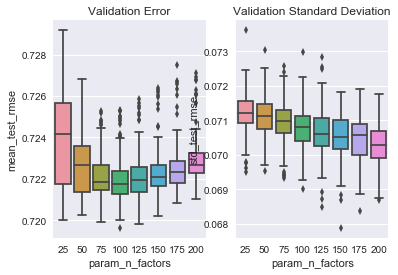

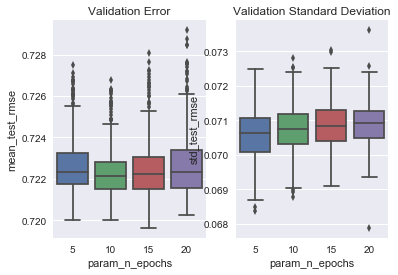

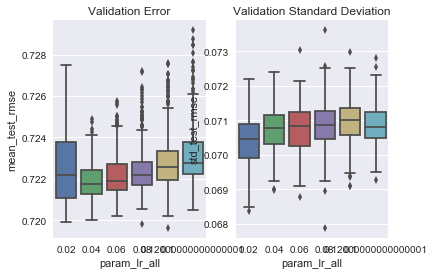

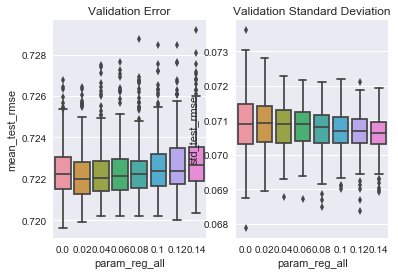

In [18]:
for par in ['n_factors', 'n_epochs', 'lr_all', 'reg_all']:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.boxplot(x= 'param_' + par, y="mean_test_rmse", data = results_df, ax=ax1)
    ax1.set_title('Validation Error')
    
    sns.boxplot(x='param_' + par, y="std_test_rmse", data = results_df, ax=ax2)
    ax2.set_title('Validation Standard Deviation')
    
    plt.show()

## SVD Plus Plus

This modification makes an additional adjustment where an additional term is used to capture implicit ratings. This term assumes that the a user rating an item implies they initially had some interest in the model.

In [20]:
param_grid = {'n_factors'  : np.arange(25, 100, 25),
              'n_epochs'   : np.arange(10, 25, 5),
              'lr_all'     : np.arange(0.02, 0.1, 0.02),
              'reg_all'    : np.arange(0.02, 0.1, 0.02)}

clf_svdpp = GridSearchCV(SVDpp,
                   param_grid)

clf_svdpp.fit(data)
results_df = pd.DataFrame.from_dict(clf_svdpp.cv_results)
results_df.sort_values('mean_test_rmse', inplace = True)
results_df.head(10)

,mean_fit_time,mean_test_mae,mean_test_rmse,mean_test_time,param_lr_all,param_n_epochs,param_n_factors,param_reg_all,params,rank_test_mae,...,split2_test_mae,split2_test_rmse,split3_test_mae,split3_test_rmse,split4_test_mae,split4_test_rmse,std_fit_time,std_test_mae,std_test_rmse,std_test_time
3,0.100250,0.553266,0.724387,0.002401,0.02,10,25,0.08,"{'n_factors': 25, 'n_epochs': 10, 'lr_all': 0....",67,...,0.528237,0.683037,0.565136,0.713672,0.596850,0.815530,0.012100,0.025544,0.049170,0.001359
19,0.153854,0.549906,0.726164,0.000803,0.02,15,25,0.08,"{'n_factors': 25, 'n_epochs': 15, 'lr_all': 0....",41,...,0.526167,0.683057,0.562517,0.715774,0.593135,0.817057,0.012178,0.025701,0.050089,0.001606
17,0.138613,0.549747,0.726276,0.000000,0.02,15,25,0.04,"{'n_factors': 25, 'n_epochs': 15, 'lr_all': 0....",38,...,0.532931,0.687663,0.563545,0.717414,0.587388,0.813072,0.011385,0.023028,0.047308,0.000000
55,0.113031,0.553384,0.727385,0.005380,0.04,10,50,0.08,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",68,...,0.526626,0.684046,0.568384,0.718240,0.595398,0.815878,0.011863,0.025763,0.048407,0.005805
139,0.302945,0.551347,0.727496,0.006237,0.06,20,75,0.08,"{'n_factors': 75, 'n_epochs': 20, 'lr_all': 0....",51,...,0.528383,0.686388,0.562417,0.716665,0.590602,0.815187,0.044645,0.022922,0.047609,0.007638
2,0.103761,0.557123,0.727758,0.001401,0.02,10,25,0.06,"{'n_factors': 25, 'n_epochs': 10, 'lr_all': 0....",93,...,0.534388,0.688973,0.567883,0.716293,0.597806,0.816861,0.012439,0.023531,0.048137,0.001745
111,0.134261,0.554749,0.727775,0.000000,0.08,10,75,0.08,"{'n_factors': 75, 'n_epochs': 10, 'lr_all': 0....",75,...,0.529111,0.684517,0.565092,0.716229,0.592363,0.817243,0.009487,0.022578,0.048955,0.000000
67,0.166521,0.556747,0.727875,0.006251,0.02,15,50,0.08,"{'n_factors': 50, 'n_epochs': 15, 'lr_all': 0....",90,...,0.532289,0.685625,0.569585,0.717272,0.598835,0.817837,0.015512,0.025459,0.049320,0.007656
63,0.124271,0.548821,0.727986,0.000801,0.08,10,50,0.08,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",31,...,0.525947,0.687061,0.567807,0.720791,0.584560,0.814187,0.015551,0.023641,0.047855,0.001601
1,0.102272,0.557680,0.728230,0.001600,0.02,10,25,0.04,"{'n_factors': 25, 'n_epochs': 10, 'lr_all': 0....",100,...,0.538960,0.690411,0.570408,0.718667,0.599091,0.817045,0.006882,0.024799,0.048265,0.001960


# Identify Meaning of Directions

The SVD algorithm gets us a combination of user X constant X item matrices. If we look at the first directions of the user and item matrices, we may be able to infer certain trends in the items most influencing the direction. Fit a simple model, and let's see if we can identify patterns. 

### Items

In [21]:
new_clf = clf_svd.best_estimator['rmse']
train = data.build_full_trainset()
new_clf.fit(train)

train_frame = pd.DataFrame(new_clf.qi[:,:5])
train_frame['Recipe'] = np.nan
for key, value in zip(train._raw2inner_id_items.keys(),
                      train._raw2inner_id_items.values()):
    train_frame['Recipe'].iloc[value] = key


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
def to_rating(x):
    try:
        x = pd.to_numeric(x) / 10
        x = x.mean()
    except:
        x = None
        
    return x

df_desc = [{'Recipe' : beer.ratings.Recipe.iloc[0],
            'Style'  : beer.style,
            'ABV'    : beer.abv,
            'Taste'  : beer.taste_rat,
            'Bitter' : beer.bitter,
            'Rating' : to_rating(beer.ratings.Rating),
            'Name'   : beer.name} for beer in receps]
df_desc = pd.DataFrame.from_dict(df_desc)

df_desc = pd.merge(train_frame, 
                   df_desc, 
                     how = 'left',
                     on  = 'Recipe')
df_desc['Name'] = [x.split(' - ')[0] for x in df_desc['Name']]
df_desc['Diff'] = df_desc[0] + df_desc[1]
df_desc['Recipe']= [x.replace('recipes/', '') for x in df_desc['Recipe']]

In [24]:
print(df_desc.\
          sort_values(0)[['Recipe', 'Bitter', 'ABV', 'Style', 'Name', 'Rating']].\
              head(10))
print('\n****************************************************************************\n')
print(df_desc.\
          sort_values(0)[['Recipe', 'Bitter', 'ABV', 'Style', 'Name', 'Rating']].\
              tail(10))

    Recipe     Bitter   ABV                          Style  \
263   8714  40.2 IBUs  6.1%            Oatmeal Stout (13C)   
275    655  31.2 IBUs  8.8%           Belgian Dubbel (18B)   
114   1449  26.1 IBUs  5.1%       American Amber Ale (10B)   
32   17432  85.2 IBUs  8.1%             Imperial IPA (14C)   
68   19392  27.8 IBUs  6.7%            Robust Porter (12B)   
289   6003  15.1 IBUs  3.0%      Scottish Light 60/- ( 9A)   
164   2048  11.4 IBUs  5.5%         Flanders Red Ale (17B)   
104  17650  58.5 IBUs  6.4%              Sweet Stout (13B)   
112    742  20.0 IBUs  8.6%  Belgian Dark Strong Ale (18E)   
97     886  27.8 IBUs  8.0%           Belgian Tripel (18C)   

                                        Name    Rating  
263                          Charlie O Stout  4.500000  
275                      Dubble Dog Dare You  4.000000  
114                          Rapture Red Ale  4.533333  
32                  Citra Double IPA (clone)       NaN  
68              Ladyface Picture

So there is no direct interpretaion of the primary principal direction, only patterns that can be inferred. By taking recipes at the top and bottom of the direction, we try to create patterns and put a name on what is going on in the background. Looking through the names at the top, descriptions using the words 'vanilla', 'citra', and 'ladyface' imply that the recipes are more sweet. This appears to be supported by the generally lower bitterness of the recipes at the top compared to recipes at the bottom. 

In [26]:
print(df_desc.\
          sort_values(1)[['Recipe', 'Bitter', 'ABV', 'Style', 'Name', 'Rating']].\
              head(10))
print('\n****************************************************************************\n')
print(df_desc.\
          sort_values(1)[['Recipe', 'Bitter', 'ABV', 'Style', 'Name', 'Rating']].\
              tail(10))

    Recipe     Bitter   ABV                                 Style  \
103   1673  22.2 IBUs  5.0%                  Specialty Beer (23A)   
20    1645  59.4 IBUs  6.8%                    American IPA (14B)   
238   1299  43.4 IBUs  5.4%                   Munich Dunkel (13A)   
290   2526  20.1 IBUs  6.9%  Spice, Herb, or Vegetable Beer (21A)   
16   12366  43.6 IBUs  4.8%               American Pale Ale (10A)   
154    211  30.5 IBUs  5.8%               American Pale Ale (10A)   
187  14627  57.7 IBUs  5.1%                    American IPA (14C)   
179   1285  30.7 IBUs  5.2%         Northern German Pilsner ( 2B)   
271  12564  20.5 IBUs  8.7%                          Saison (16C)   
276  32145  53.5 IBUs  7.5%                  Imperial Stout (13F)   

                                 Name    Rating  
103                        Club SMaSH  4.000000  
20            Bell\'s Two Hearted IPA  4.650602  
238       Olaf\'s Bavarian Dark Lager  4.000000  
290                        Punkin Ale  4

Moving to the second direction, we see wheatbeers near the bottom, and a lot of american themed beers at the top. Again, there also appears to be less bitterness at the top as a whole than the bottom. Perhaps this is a more savory direction. 

### Users

This is incredibly difficult to determine at the user level, so I will include this for brevity, but skip the major part of the analysis. Users on opposite end of the spectrum should enjoy opposite palletes of beer. 

In [27]:
train_frame = pd.DataFrame(new_clf.pu[:,:5])
train_frame['User'] = np.nan
           
for key, value in zip(train._raw2inner_id_users.keys(),
                      train._raw2inner_id_users.values()):
    train_frame['User'].iloc[value] = key

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
print(train_frame.\
          sort_values(0)[[0, 1, 'User']].\
              head(10))
print('\n\n')
print(train_frame.\
          sort_values(0)[[0, 1, 'User']].\
              tail(10))


            0         1             User
198 -0.350680 -0.049124    8394/jfrollup
334 -0.313242  0.037473   57652/agaricus
100 -0.306669  0.111177   18052/zaluskim
101 -0.291631 -0.027464  15679/phelanka7
186 -0.289160 -0.028699  4990/savorychef
381 -0.284640 -0.057814      44049/tarha
0   -0.279610 -0.088575          18/newt
526 -0.268881  0.067922  77697/wasyussef
77  -0.257644 -0.095027  618/zymurgist05
377 -0.251962  0.087452  32519/wandzurab



            0         1                     User
353  0.209576  0.250901       76296/rcoimbra1973
184  0.212463 -0.046211             674/jimieb99
162  0.218009  0.062202  92629/barbarosbrewingco
460  0.224592 -0.015506            13775/daehlin
108  0.228820  0.150152           29093/goadtoof
82   0.237481  0.032906        110398/gazzbrewer
76   0.242183  0.009483     167350/robertosm2018
515  0.247500 -0.109860          4600/lexuschris
378  0.266736 -0.028326                 8616/jvh
33   0.310231  0.115479            14744/collier


## Napoleon Dynamite Effect

The Napolean Dynamite Effect comes from the Netflix Prize, where the participants noticed certain movies had polarizing ratings. We can infer the same pattern here, where we use 5 fold cv to generate pseudo OOS predictions, and identify the cases where those predictions perform the worst. 

In [29]:
new_clf = clf_svd.best_estimator['rmse']
cv      = KFold(n_splits = 5, random_state = 1234)

store   = []
for train_set, test_set in cv.split(data):
    new_clf.fit(train_set)
    predictions = new_clf.test(test_set)
    
    for pred, known in zip(predictions, test_set):
        known = list(known)
        known.append(pred.est)
        store.append(known)
store = [{'User'   : x[0],
          'Recipe' : x[1],
          'True'   : x[2],
          'Pred'   : x[3]} for x in store]
    
store = pd.DataFrame.from_dict(store)
store['error'] = (store['Pred'] - store['True'])**2
store['cnt']   = 1
     
store = store.\
    groupby('Recipe')[['error', 'cnt']].\
           sum().\
              sort_values('error', ascending = False)

In [30]:
print(store[store['cnt'] > 2])

            error  cnt
Recipe                
1645    17.219393   63
211     12.815726    3
653      9.840133   37
17432    8.201427   35
3684     7.186651   21
1449     6.305701   12
17560    5.494283   31
10490    4.376108    3
199      3.256533   12
2762     2.721791    9
654      2.207026    9
688      1.982008    4
1618     1.820847    3
1254     1.789970    7
35106    1.670006    5
1137     1.448498    5
1834     1.425474    9
742      1.414664    3
6503     1.307415    3
3898     1.268977    4
14589    1.121239    5
2520     1.089744    4
2642     1.032839    6
2275     1.000572    4
3057     0.928547    4
740      0.888154    4
12366    0.884807    4
717      0.875147    3
1419     0.793594    3
14573    0.656615    3
710      0.623624    6
2282     0.557125    4
727      0.535246    3
1438     0.500129    3
1369     0.487062    4
2535     0.232045   10
4472     0.161833    4


Recipe 211 showed up when we looked at the standard deviation of ratings. Interestingly, it looks like the algorithm is getting the most rated recipes wrong. This is a sign of overfitting which may be present in the current setup. Perhaps we should lean to algorithms with more bias and lower CV scores. 

# Final Model Selection

In the previous sections, we fit 3 models and established a benchmark. In this section, we pick from thosd models as a final solution. We use the same CV set we used on the benchmark, and set our final model. Then we evaluate the model on the test set to get an estimate of model error. Out of the principal of Ocam's Razor, if we do not exceed benchmark performance, we should prefer the simpler solution.

In [31]:
cv_method    = RepeatedKFold(
                      n_splits = 5, 
                      n_repeats = 10, 
                      random_state = 42)

err = []
for algo in [clf_knn.best_estimator['rmse'],
             clf_svd.best_estimator['rmse'],
             clf_svdpp.best_estimator['rmse']]:            

    #CV
    cv_score     = evaluator(algo, 
                             data, 
                             cv_method)
    #Bias
    train_set    = data.build_full_trainset()
    algo.fit(train_set)
    preds        = algo.test(train_set.build_testset())
    bias         = accuracy.rmse(preds)
    
    #Error
    test_set     = data.construct_testset(test_ratings)
    preds        = algo.test(test_set)
    err.append(accuracy.rmse(preds))
    
    #Baseline CV
    print('\nModel CV avg:\t' + str(cv_score[0]))
    print('\nModel CV std:\t' + str(cv_score[1]))
    print('\nModel bias:\t' + str(bias) + '\n')

RMSE: 0.8136
RMSE: 0.6716
RMSE: 0.7975
RMSE: 0.8289
RMSE: 0.7951
RMSE: 0.7793
RMSE: 0.6155
RMSE: 0.6961
RMSE: 0.8769
RMSE: 0.7925
RMSE: 0.7087
RMSE: 0.8116
RMSE: 0.8655
RMSE: 0.7107
RMSE: 0.7407
RMSE: 0.9010
RMSE: 0.7068
RMSE: 0.6425
RMSE: 0.9074
RMSE: 0.7382
RMSE: 0.7784
RMSE: 0.8111
RMSE: 0.8195
RMSE: 0.5949
RMSE: 0.8441
RMSE: 0.6804
RMSE: 0.8047
RMSE: 0.7941
RMSE: 0.7151
RMSE: 0.8462
RMSE: 0.7244
RMSE: 0.8578
RMSE: 0.7218
RMSE: 0.7843
RMSE: 0.7818
RMSE: 0.7825
RMSE: 0.6745
RMSE: 0.7608
RMSE: 0.8292
RMSE: 0.8125
RMSE: 0.8121
RMSE: 0.6674
RMSE: 0.7156
RMSE: 0.8659
RMSE: 0.7955
RMSE: 0.7658
RMSE: 0.9088
RMSE: 0.6770
RMSE: 0.7744
RMSE: 0.7598
RMSE: 0.2616
RMSE: 0.8753

Model CV avg:	0.7712168581327313

Model CV std:	0.07468062495242779

Model bias:	0.26158544648066173

RMSE: 0.7735
RMSE: 0.5752
RMSE: 0.6753
RMSE: 0.8067
RMSE: 0.7834
RMSE: 0.7598
RMSE: 0.5749
RMSE: 0.6494
RMSE: 0.8540
RMSE: 0.7768
RMSE: 0.6696
RMSE: 0.7678
RMSE: 0.8424
RMSE: 0.6012
RMSE: 0.7213
RMSE: 0.7180
RMSE: 0.6882


The SVD models perform best, with the SVDpp model showing both the lowest CV score, and lowest standard deviation of the score. In addition, the microscopic bias of the SVD model implies that all of the performance is coming from variance. With a known overfitting issue, I prefer the SVDpp model. 

### OOS Error

Having established the model, we now look to the OOS error, to see if we have improved on the benchmark error of 0.81229.

In [32]:
print(err)
algo = clf_svdpp.best_estimator['rmse']

[0.8752502961573349, 0.8087346303924627, 0.8056062026968732]


That was a lot of work for a small incremental improvement. Oh well, it looks like the model is an improvment, and that the process is more sound.

# Number of Items to Serve

Having set a model, we look to set the number of items to serve to the client. This is more tied to the business problem than the individual user. For this problem, we are trying to come up with new ideas, so we do not want to serve something that the user has already rated.

The measure of a good number is the recall. Recall is a measure of the percentage of items served to the user, that the user will rate positively. With a continuous rating system, we have to set a threshold to establish what a positive rating is, and vary the number of items and look at how recall evolves with the number of items. We can do this at varying thresholds. 

In [33]:
def precision_recall_at_k(predictions, k=10, threshold=4):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

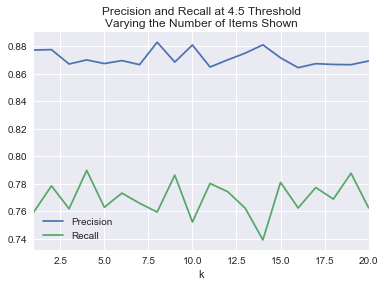

In [34]:
store_outer = []
store_inner = []

data.raw_ratings = train_ratings + test_ratings

cv = KFold()

for num in range(1, 21):
    for cut_off in np.arange(2.5, 5, 0.25):
        store_inner = []
        for trainset, testset in cv.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, 
                                                        k = num, 
                                                        threshold = cut_off)
            
            #Fix here to add threshold
            store_inner.append(pd.DataFrame({'Precision'  : [sum(prec for prec in precisions.values()) / len(precisions)],
                                        'recalls'    : [sum(rec for rec in recalls.values()) / len(recalls)],
                                        'Count'      : [len(predictions)]}))    
        store_inner = pd.concat(store_inner)
        store_inner['Precision'] = store_inner['Precision'] * store_inner['Count']
        store_inner['recalls']   = store_inner['recalls'] * store_inner['Count']
        store_inner              = store_inner.sum()
        store_inner['Precision'] = store_inner['Precision'] / store_inner['Count']
        store_inner['recalls']   = store_inner['recalls'] / store_inner['Count']
        store_inner['k']         = num
        store_inner['threshold'] = cut_off
        store_outer.append(store_inner)

df_result = pd.concat(store_outer, axis = 1)
df_result = df_result.transpose()
df_result.index = df_result.k
df_result.rename(columns = {'recalls' : 'Recall'}, inplace = True)
df_result[df_result['threshold']==4.5][['Precision', 'Recall']].\
    plot(title = 'Precision and Recall at 4.5 Threshold\nVarying the Number of Items Shown')

It looks liek 9 is a good trade-off between preserving recall and not underwhelming or overwhelming the user. In production systemss, we can perterb this and measure the effect on KPIs. For this project, we can just hold it as is. 

# Bootstrap Data

After going through the process of model development, the easiest way to improve a model is by increasing the data size. In webscraping, I was told to hold off for a few weeks by the website, so adding more data at the moment is not possible. Examine the impact on the model of increasing the size of the data when we can. 

In [45]:
hold_data = data.raw_ratings

results_l   = []
n_samples   = 500
for ii in [10, 100, 250, 500, 750, 800]:
    results_m   = []
    results_s   = []

    for jj in range(n_samples):    
        random.shuffle(hold_data)
        train_ratings    = hold_data[:ii]
        test_ratings     = hold_data[ii:]
        data.raw_ratings = train_ratings
        algo.fit(data.build_full_trainset())        
        preds        = algo.test(data.construct_testset(test_ratings))        
        err          = accuracy.rmse(preds)

        results_m.append(err)
        results_s.append(err**2)
    results_l.append({'Count' : ii,
                      'Mean'  : sum(results_m) / n_samples,
                      'Second': sum(results_s) / n_samples})
    print(ii)
    
data.raw_ratings = hold_data
df = pd.DataFrame.from_dict(results_l)
df['Training Set Size'] = df['Count']
df.index = df['Training Set Size']

RMSE: 0.7767
RMSE: 0.7912
RMSE: 0.7737
RMSE: 1.0138
RMSE: 1.1624
RMSE: 0.7773
RMSE: 0.7774
RMSE: 0.7839
RMSE: 0.7923
RMSE: 0.8087
RMSE: 0.7755
RMSE: 0.8895
RMSE: 0.7962
RMSE: 0.7708
RMSE: 0.7767
RMSE: 0.7667
RMSE: 0.7881
RMSE: 0.8523
RMSE: 0.8107
RMSE: 0.8445
RMSE: 0.7761
RMSE: 0.7776
RMSE: 0.7736
RMSE: 0.7844
RMSE: 0.7998
RMSE: 0.7843
RMSE: 0.8097
RMSE: 0.7799
RMSE: 0.8022
RMSE: 0.8106
RMSE: 0.7756
RMSE: 0.8005
RMSE: 0.7743
RMSE: 0.7849
RMSE: 0.7757
RMSE: 0.8108
RMSE: 0.8377
RMSE: 0.7667
RMSE: 0.7819
RMSE: 0.8110
RMSE: 0.7751
RMSE: 0.7715
RMSE: 0.7882
RMSE: 0.8158
RMSE: 0.7741
RMSE: 0.7885
RMSE: 0.8447
RMSE: 0.7917
RMSE: 0.7868
RMSE: 0.7973
RMSE: 0.7871
RMSE: 0.7774
RMSE: 0.7685
RMSE: 0.8448
RMSE: 0.7774
RMSE: 0.8093
RMSE: 0.7892
RMSE: 0.7909
RMSE: 0.8114
RMSE: 0.7737
RMSE: 0.7887
RMSE: 0.7741
RMSE: 0.8116
RMSE: 0.7909
RMSE: 0.7774
RMSE: 0.7867
RMSE: 0.7754
RMSE: 0.8465
RMSE: 0.8114
RMSE: 0.8206
RMSE: 0.7855
RMSE: 0.7737
RMSE: 0.9032
RMSE: 0.8079
RMSE: 0.7863
RMSE: 0.7769
RMSE: 0.7756

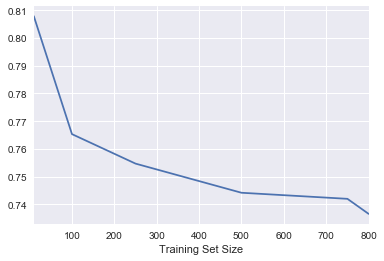

In [48]:
df.Mean.plot()

It looks like we are still in a phase where we can substantially improve by adding more data. I think when the strongly suggested cooling off period is over, I will continue to scrape the website. 

# Recommendation for a New Brewer

As a the obvious final step, we take a new user and make a suggested list for them. I picked out tx-brewer because he had rated some recipes that looked good to me at a glance. Let's see what else he would like. 

In [49]:
res = []
for key, value in zip(train_set._raw2inner_id_items.keys(),
                      train_set._raw2inner_id_items.values()):
    pred = algo.predict(train_set._raw2inner_id_users['2891/tx-brewer'], 
                        value)
    res.append({'User' : '2891/tx-brewer',
                'Item' : key,
                'Value' :pred.est})
res    = pd.DataFrame.from_dict(res)
prev_serv = ratings[ratings['User'] == '2891/tx-brewer']['Recipe'].values

res    = res[[x not in prev_serv for x in res['Item']]]
res.sort_values('Value', inplace = True, ascending = False)
res    = res.head(30)
res['Item'] = [x.replace('recipes/', '') for x in res['Item']]
res = pd.merge(res,
            df_desc[['Recipe', 'ABV', 'Bitter', 'Name', 'Rating', 'Style', 'Taste']],
            left_on = 'Item', 
            right_on = 'Recipe')
res = res.head(9)
res = res[['Item', 'Recipe', 'User', 'Value', 'ABV', 'Bitter', 'Name', 'Rating', 'Style', 'Taste']]
print('Results for tx-brewer:\n\n')
print(res)

Results for tx-brewer:


    Item Recipe            User   Value    ABV     Bitter  \
0   1132   1132  2891/tx-brewer  4.3725   4.5%  12.1 IBUs   
1    623    623  2891/tx-brewer  4.3725   4.5%  30.5 IBUs   
2   4540   4540  2891/tx-brewer  4.3725   4.4%  21.5 IBUs   
3    631    631  2891/tx-brewer  4.3725   5.6%  33.2 IBUs   
4    607    607  2891/tx-brewer  4.3725   5.7%  31.3 IBUs   
5   1344   1344  2891/tx-brewer  4.3725   5.8%  36.8 IBUs   
6    195    195  2891/tx-brewer  4.3725   6.6%  44.4 IBUs   
7  22069  22069  2891/tx-brewer  4.3725  11.0%  22.2 IBUs   
8    534    534  2891/tx-brewer  4.3725   5.8%  39.5 IBUs   

                           Name    Rating  \
0              Lemon Hefeweizen  4.666667   
1          Brewer\'s Best Steam  1.500000   
2  Angry Cat Scottish 80  (1.1)  3.000000   
3                    Burton Ale  4.000000   
4                     Alty Beer  3.000000   
5                       DS Pale  5.000000   
6              ItsTooHot\'s APA  4.000000   
7   

Interestingly, one of the recipes had an extremely low rating. Upon closer inspection, it looks like the two raters had an opposite pallate to tx-brewer. In addition, there are quite a few wheat beers and American Pale Ales that made it onto the list. This is in line with what the user has historically rated. 